<a href="https://colab.research.google.com/github/lwbaleeiro/vencimentos-contratos-b3/blob/main/Vencimentos_de_contrato.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Consultar Vencimentos de contratos em aberto B3**

---



In [ ]:
!pip install selenium
!apt install chromium-chromedriver

Reading package lists... Done
Building dependency tree       
Reading state information... Done
chromium-chromedriver is already the newest version (87.0.4280.66-0ubuntu0.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


In [ ]:
import datetime
import openpyxl as xls
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from selenium import webdriver
from tabulate import tabulate
from matplotlib.backends.backend_pdf import PdfPages

In [ ]:
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
wd = webdriver.Chrome('chromedriver', options = options)
driver = webdriver.Chrome('chromedriver', options = options)

In [ ]:
def getPreviousDay():
  today = datetime.datetime.now()
  offset = max(1, (today.weekday() + 6) % 7 - 3)
  timedelta = datetime.timedelta(offset)
  return today - timedelta

# **Vencimentos e séries autorizadas**
---

In [ ]:
driver.get('http://www2.bmf.com.br/pages/portal/bmfbovespa/lumis/lum-vencimentos-autorizados-ptBR.asp?cboMercado=3&cboMercadoria=2-DOL')

In [ ]:
#Pega todas as tabelas
dados = driver.find_element_by_id("table_2")
html = dados.get_attribute("innerHTML")
soup = BeautifulSoup(html, "html.parser")
tables = soup.find_all("table")

#Pegou do Proximo Mês
codCompra, preco, codVenda, vencimento = [], [], [], []

table = tables[0].find('tbody')
rows = table.find_all('tr')
for row in rows:
    cols = row.find_all('td')
    codCompra.append(cols[1].text.replace("DOL",""))
    preco.append(cols[2].text.replace(".00",""))
    codVenda.append(cols[3].text.replace("DOL",""))

opcoesCompraDol = pd.DataFrame(list(zip(codCompra, preco)), columns = ['Serie','Preço'])
opcoesVendaDol = pd.DataFrame(list(zip(codVenda, preco)), columns = ['Serie','Preço'])

tableThread = tables[0].find('thead')
rowsTr = tableThread.find_all('tr')
for row in rowsTr:
  colsTh = row.find_all('th')
  vencimento.append(colsTh[0].get_text(strip=True).replace('\n', '').replace('\t', ''))

vencimentoTabela1 = vencimento[0]

#Pegou do Outro Mês
codCompra, preco, codVenda, vencimento = [], [], [], []

table = tables[1].find('tbody') 
rows = table.find_all('tr')
for row in rows:
    cols = row.find_all('td')
    codCompra.append(cols[1].text.replace("DOL",""))
    preco.append(cols[2].text.replace(".00",""))
    codVenda.append(cols[3].text.replace("DOL",""))

opcoesCompraDol2 = pd.DataFrame(list(zip(codCompra, preco)), columns = ['Serie','Preço'])
opcoesVendaDol2 = pd.DataFrame(list(zip(codVenda, preco)), columns = ['Serie','Preço'])

tableThread = tables[1].find('thead')
rowsTr = tableThread.find_all('tr')
for row in rowsTr:
  colsTh = row.find_all('th')
  vencimento.append(colsTh[0].get_text(strip=True).replace('\n', '').replace('\t', ''))

vencimentoTabela2 = vencimento[0]

# **Posições em aberto**
---

In [ ]:
driver.get('http://www2.bmf.com.br/pages/portal/bmfbovespa/lumis/lum-posicoes-em-aberto-opcoes-ptBR.asp')

In [ ]:
dados = driver.find_element_by_xpath("/html/body/div[1]/div[7]/div")
html = dados.get_attribute("innerHTML")
soup = BeautifulSoup(html, "html.parser")
table = soup.select_one("table")

codSerie, contratos, variacao = [], [], []
rows = table.find_all('tr')
for row in rows:
	cols = row.find_all('td')
	if len(cols) == 3:
		codSerie.append(cols[0].text)
		contratos.append(cols[1].text.replace(".",""))
		variacao.append(cols[2].text)

series = pd.DataFrame(list(zip(codSerie, contratos, variacao)), columns = ['Serie','Num. Contratos','Variacao'])

## Posições em aberto com vencimento anterior

In [ ]:
driver.find_element_by_id('dData1').click() 
dataHtml = driver.find_element_by_id('dData1')
dataHtml.clear()
dataHtml.send_keys(getPreviousDay().strftime('%d/%m/%Y'))
driver.find_element_by_css_selector('button[type=submit]').click()

dados = driver.find_element_by_xpath("/html/body/div[1]/div[7]/div")
html = dados.get_attribute("innerHTML")
soup = BeautifulSoup(html, "html.parser")
table = soup.select_one("table")
  
codSerie, contratos, variacao = [], [], []
rows = table.find_all('tr')
for row in rows:
	cols = row.find_all('td')
	if len(cols) == 3:
		codSerie.append(cols[0].text)
		contratos.append(cols[1].text.replace(".",""))
		variacao.append(cols[2].text)

seriesVencimentoAnterior = pd.DataFrame(list(zip(codSerie, contratos, variacao)), columns = ['Serie','Num. Contratos','Variacao'])

## Posição em aberto com vencimento hoje

In [ ]:
# driver.find_element_by_id('dData1').click() 
# dataHtml = driver.find_element_by_id('dData1')
# dataHtml.clear()
# dataHtml.send_keys(datetime.datetime.now().strftime('%d/%m/%Y'))
# driver.find_element_by_css_selector('button[type=submit]').click()

try:
  dados = driver.find_element_by_xpath("/html/body/div[1]/div[7]/div")
  html = dados.get_attribute("innerHTML")
  soup = BeautifulSoup(html, "html.parser")
  table = soup.select_one("table")
    
  codSerie, contratos, variacao = [], [], []
  rows = table.find_all('tr')
  for row in rows:
    cols = row.find_all('td')
    if len(cols) == 3:
      codSerie.append(cols[0].text)
      contratos.append(cols[1].text.replace(".",""))
      variacao.append(cols[2].text)

  seriesVencimentoHoje= pd.DataFrame(list(zip(codSerie, contratos, variacao)), columns = ['Serie','Num. Contratos','Variacao'])
except:
  seriesVencimentoHoje = []

# **Tratando Dados**
---



In [ ]:
# Join na tabela de Vencimentos com tabela de Opções
tabelaCompra = opcoesCompraDol.set_index('Serie').join(series.set_index('Serie'))
tabelaVenda = opcoesVendaDol.set_index('Serie').join(series.set_index('Serie'))

tabelaCompra2 = opcoesCompraDol2.set_index('Serie').join(series.set_index('Serie'))
tabelaVenda2 = opcoesVendaDol2.set_index('Serie').join(series.set_index('Serie'))

tabelaCompraVencAnterior = opcoesCompraDol2.set_index('Serie').join(seriesVencimentoAnterior.set_index('Serie'))
tabelaVendaVencAnterior = opcoesVendaDol2.set_index('Serie').join(seriesVencimentoAnterior.set_index('Serie'))

tabelaCompraVencHoje = opcoesCompraDol2.set_index('Serie').join(seriesVencimentoHoje.set_index('Serie'))
tabelaVendaVencHoje = opcoesVendaDol2.set_index('Serie').join(seriesVencimentoHoje.set_index('Serie'))

# Merge nas tabelas de Vencimento de compar e venda.
pd.set_option('display.max_rows', None)
dfVencimentoHoje = pd.merge(tabelaCompraVencHoje, tabelaVendaVencHoje, on='Preço').sort_values(by='Preço', ascending=False).replace(to_replace = np.nan, value = '0')
dfVencimentoAnterior = pd.merge(tabelaCompraVencAnterior, tabelaVendaVencAnterior, on='Preço').sort_values(by='Preço', ascending=False).replace(to_replace = np.nan, value = '0')
dfProximoVencimento = pd.merge(tabelaCompra, tabelaVenda, on='Preço').sort_values(by='Preço', ascending=False).replace(to_replace = np.nan, value = '0')
dfProximoVencimento2 = pd.merge(tabelaCompra2, tabelaVenda2, on='Preço').sort_values(by='Preço', ascending=False).replace(to_replace = np.nan, value = "0") 

# Tratamentos
dfProximoVencimento['Preço'] = dfProximoVencimento['Preço'].str.replace(',', '.')
dfProximoVencimento2['Preço'] = dfProximoVencimento2['Preço'].str.replace(',', '.')
dfVencimentoAnterior['Preço'] = dfVencimentoAnterior['Preço'].str.replace(',', '.')
dfVencimentoHoje['Preço'] = dfVencimentoHoje['Preço'].str.replace(',', '.')

dfProximoVencimento = dfProximoVencimento.rename(columns = {'Num. Contratos_x' : 'Opções compra', 'Variacao_x' : 'Variação compra', 'Num. Contratos_y' : 'Opções venda', 'Variacao_y' : 'Variação venda'})
dfProximoVencimento2 = dfProximoVencimento2.rename(columns = {'Num. Contratos_x' : 'Opções compra', 'Variacao_x' : 'Variação compra', 'Num. Contratos_y' : 'Opções venda', 'Variacao_y' : 'Variação venda'})
dfVencimentoAnterior = dfVencimentoAnterior.rename(columns = {'Num. Contratos_x' : 'Opções compra', 'Variacao_x' : 'Variação compra', 'Num. Contratos_y' : 'Opções venda', 'Variacao_y' : 'Variação venda'})
dfVencimentoHoje = dfVencimentoHoje.rename(columns = {'Num. Contratos_x' : 'Opções compra', 'Variacao_x' : 'Variação compra', 'Num. Contratos_y' : 'Opções venda', 'Variacao_y' : 'Variação venda'})

# **Gráficos & Tabela**

Text(0.5, 1.0, 'Mapa Opções Hoje')

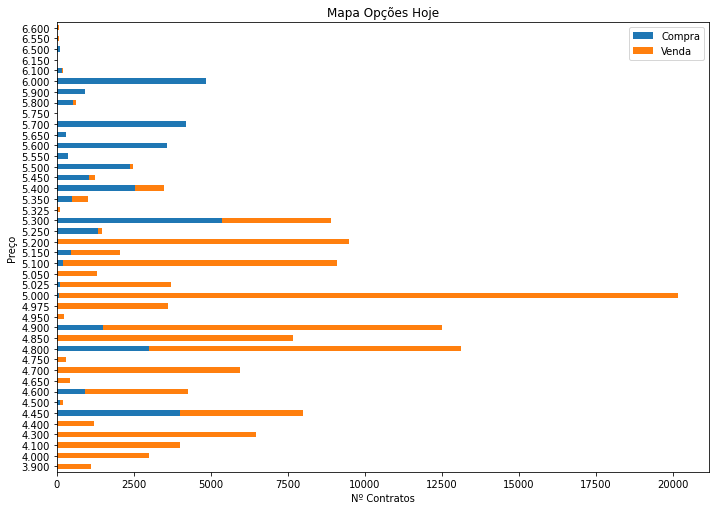

In [ ]:
qtd_compra = dfVencimentoHoje['Opções compra']
qtd_venda = dfVencimentoHoje['Opções venda']
preco = dfVencimentoHoje['Preço']

qtd_compra = list(map(int,qtd_compra.tolist()))
qtd_venda = list(map(int,qtd_venda.tolist()))
preco = list(map(str,preco.tolist()))
width = 0.35

dfMapa = pd.DataFrame({'Compra': qtd_compra, 'Venda': qtd_venda}, index=preco)
dfMapa = dfMapa[(dfMapa.T != 0).any()]

axMapa = dfMapa.plot.barh(figsize=(11.69,8.27), stacked=True)
axMapa.invert_yaxis()
axMapa.set_ylabel('Preço')
axMapa.set_xlabel('Nº Contratos')
axMapa.set_title('Mapa Opções Hoje')

Text(0.5, 1.0, 'Variação 18/12/2020')

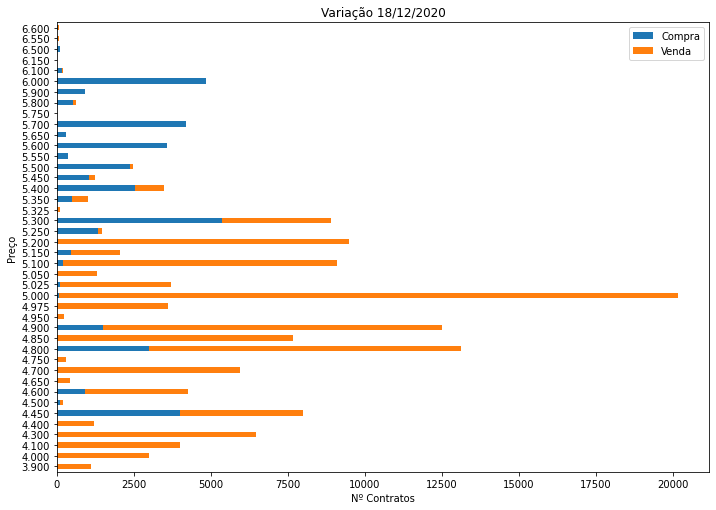

In [ ]:
qtd_compra = dfVencimentoAnterior['Opções compra']
qtd_venda = dfVencimentoAnterior['Opções venda']
preco = dfVencimentoAnterior['Preço']

qtd_compra = list(map(int,qtd_compra.tolist()))
qtd_venda = list(map(int,qtd_venda.tolist()))
preco = list(map(str,preco.tolist()))
width = 0.35

dfMapa1 = pd.DataFrame({'Compra': qtd_compra, 'Venda': qtd_venda}, index=preco)
dfMapa1 = dfMapa1[(dfMapa1.T != 0).any()]

axMapa1 = dfMapa1.plot.barh(figsize=(11.69,8.27), stacked=True)
axMapa1.invert_yaxis()
axMapa1.set_ylabel('Preço')
axMapa1.set_xlabel('Nº Contratos')
axMapa1.set_title('Variação ' + getPreviousDay().strftime('%d/%m/%Y').lower().capitalize())

Text(0.5, 1.0, 'Mapa Opções Janeiro    - 04/01/2021')

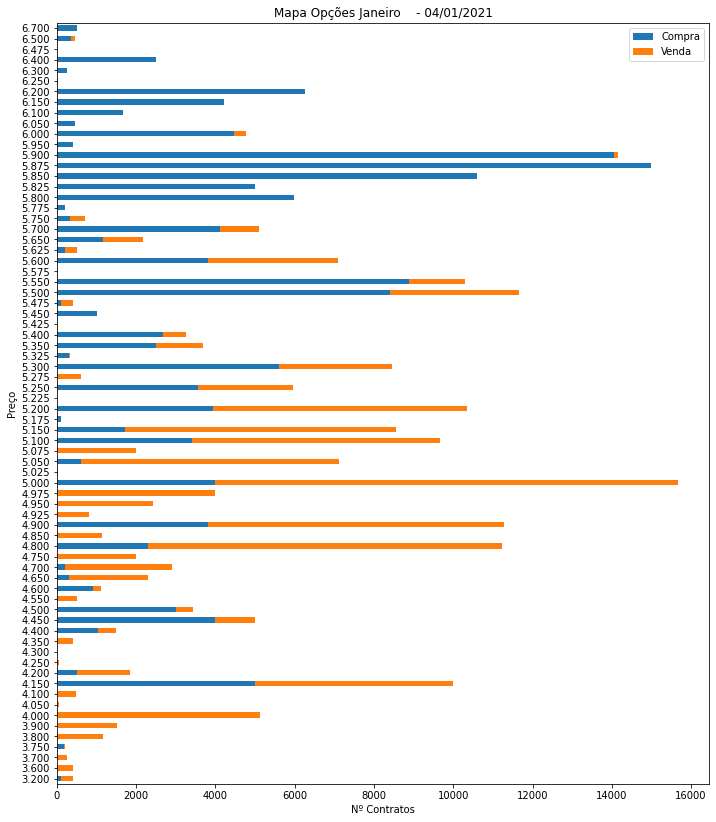

In [ ]:
qtd_compra = dfProximoVencimento['Opções compra']
qtd_venda = dfProximoVencimento['Opções venda']
preco = dfProximoVencimento['Preço']

qtd_compra = list(map(int,qtd_compra.tolist()))
qtd_venda = list(map(int,qtd_venda.tolist()))
preco = list(map(str,preco.tolist()))
width = 0.35

dfMapa2 = pd.DataFrame({'Compra': qtd_compra, 'Venda': qtd_venda}, index=preco)
dfMapa2 = dfMapa2[(dfMapa2.T != 0).any()]

axMapa2 = dfMapa2.plot.barh(figsize=(11.69, 14), stacked=True)
axMapa2.invert_yaxis()
axMapa2.set_ylabel('Preço')
axMapa2.set_xlabel('Nº Contratos')
axMapa2.set_title('Mapa Opções ' + vencimentoTabela1.lower().capitalize())

In [ ]:
qtd_compra = dfProximoVencimento2['Opções compra']
qtd_venda = dfProximoVencimento2['Opções venda']
preco = dfProximoVencimento2['Preço']

qtd_compra = list(map(int,qtd_compra.tolist()))
qtd_venda = list(map(int,qtd_venda.tolist()))
preco = list(map(str,preco.tolist()))
width = 0.35

dfMapa3 = pd.DataFrame({'Compra': qtd_compra, 'Venda': qtd_venda}, index=preco)
dfMapa3 = dfMapa3[(dfMapa3.T != 0).any()]

axMapa3 = dfMapa3.plot.barh(figsize=(11.69, 9), stacked=True)
axMapa3.invert_yaxis()
axMapa3.set_ylabel('Preço')
axMapa3.set_xlabel('Nº Contratos')
axMapa3.set_title('Mapa Opções ' + vencimentoTabela2.lower().capitalize())

(0.0, 1.0, 0.0, 1.0)

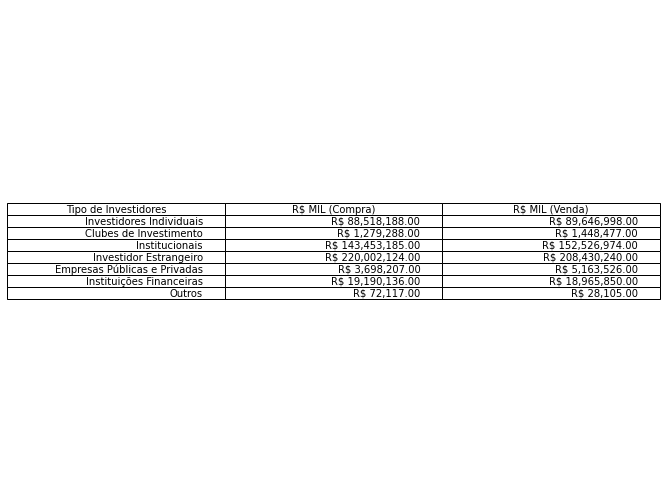

In [ ]:
# Participação de Investidores
dfExcel = pd.read_excel('http://www.b3.com.br/data/files/37/37/DE/3C/3FF247102255C247AC094EA8/participacao.xlsx', 'pub_site')
dfExcel = dfExcel.rename(columns = {'Unnamed: 0' : 'Tipo de Investidores', 'Participação dos Investidores no Volume Total do Segmento Bovespa' : 'R$ MIL (Compra)', 'Unnamed: 2' : 'Part. (% Compra)', 'Unnamed: 3' : 'R$ MIL (Venda)', 'Unnamed: 4' : 'Part. (% Venda)'})
dfExcel = dfExcel.drop(columns=['Part. (% Compra)', 'Part. (% Venda)'])
dfExcel = dfExcel.drop([0, 1, 2, 3])

dfExcel['R$ MIL (Compra)'] = dfExcel['R$ MIL (Compra)'].apply(lambda x: "R$ {:0,.2f}".format((x/1)))
dfExcel['R$ MIL (Venda)'] = dfExcel['R$ MIL (Venda)'].apply(lambda x: "R$ {:0,.2f}".format((x/1)))

figInvestidores = plt.figure(figsize=(11.69, 9))

ax = figInvestidores.add_subplot()
cell_text = []
for row in range(len(dfExcel)):
  cell_text.append(dfExcel.iloc[row])

ax.table(cellText=cell_text, colLabels=dfExcel.columns, loc='center')
ax.axis('off')


In [ ]:
with PdfPages('vencimento_contratos_' + datetime.datetime.now().strftime('%d_%m_%Y').lower().capitalize() + '.pdf') as pdf:
  pdf.savefig(figInvestidores)
  plt.close()

  pdf.savefig(axMapa.figure)  
  plt.close()

  pdf.savefig(axMapa1.figure)  
  plt.close()

  pdf.savefig(axMapa2.figure)  
  plt.close()

  pdf.savefig(axMapa3.figure)
  plt.close()